In [115]:
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
from tabulate import tabulate
from ta.momentum import RSIIndicator
import ta

class StockAnalysis:
    def __init__(self, tickers, start_date, end_date):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.results = []
        self.closing_prices_df = pd.DataFrame()

    def fetch_stock_data(self, ticker):
        return yf.download(ticker, start=self.start_date, end=self.end_date, progress=False)

    def prepare_prophet_data(self, stock_data):
        prophet_data = stock_data.reset_index()[["Date", "Close"]]
        prophet_data.rename(columns={"Date": "ds", "Close": "y"}, inplace=True)
        return prophet_data

    def calculate_slope(self, stock_data):
        x = np.arange(len(stock_data)).reshape(-1, 1)
        y = stock_data["Close"].values.reshape(-1, 1)
        model = LinearRegression()
        model.fit(x, y)
        slope = model.coef_[0][0]
        return slope

    def fetch_fundamental_data(self, ticker):
        fundamental_data = {}
        stock_info = yf.Ticker(ticker)
        try:
            pe_ratio = stock_info.info['trailingPE']
            beta = stock_info.info['beta']
            pb_ratio = stock_info.info['priceToBook']
        except KeyError:
            pe_ratio = None
            beta = None
            pb_ratio = None
        fundamental_data['P/E Ratio'] = pe_ratio
        fundamental_data['Beta'] = beta
        fundamental_data['P/B Ratio'] = pb_ratio
        return fundamental_data

    def fetch_dividend_data(self, ticker):
        dividend_data = []
        stock_info = yf.Ticker(ticker)
        dividends = stock_info.dividends.reset_index()
        for _, row in dividends.iterrows():
            dividend_data.append((row['Date'], row['Dividends']))
        return dividend_data

    def calculate_rsi(self, stock_data):
        close_prices = stock_data["Close"]
        rsi_indicator = RSIIndicator(close_prices, window=14)
        rsi = rsi_indicator.rsi()
        return rsi

    def assign_points(self, value, conditions):
        for threshold, points in conditions.items():
            if value < threshold:
                return points
        return 0

    def analyze_tickers(self):
        slope_conditions = {0.10: 0, 0.20: 1, 0.30: 2, 0.40: 3}
        pe_conditions = {7: 0, 14: 4, 15: 3, 25: 2, 35: 1, 40: 0}
        beta_conditions = {0.80: 4, 1.0: 3, 1.4: 2, 1.9: 1, 2.0: 0, 3.0: -1}
        pb_conditions = {1: 2, 2: 1}
        rsi_conditions = {30: 2, 40: 1, 70: -2, 80: -1}

        for ticker in self.tickers:
            stock_data = self.fetch_stock_data(ticker)
            self.closing_prices_df[ticker] = stock_data["Close"]
            slope = self.calculate_slope(stock_data)
            fundamental_data = self.fetch_fundamental_data(ticker)
            pe_ratio = fundamental_data['P/E Ratio']
            beta = fundamental_data['Beta']
            pb_ratio = fundamental_data['P/B Ratio']
            rsi = self.calculate_rsi(stock_data)

            slope_points = self.assign_points(slope, slope_conditions)
            pe_points = self.assign_points(pe_ratio, pe_conditions)
            beta_points = self.assign_points(beta, beta_conditions)

            if pb_ratio < 1:
                pb_points = 3
            elif pb_ratio == 1:
                pb_points = 2
            else:
                pb_points = 0

            dividend_data = self.fetch_dividend_data(ticker)
            dividend_points = 1 if len(dividend_data) > 0 else 0

            rsi_points = self.assign_points(rsi.iloc[-1], rsi_conditions)

            total_points = slope_points + pe_points + beta_points + pb_points + dividend_points + rsi_points
            combined_points = total_points

            if combined_points < 3:
                recommendation = "Sell"
            elif combined_points < 5:
                recommendation = "Don't buy"
            elif combined_points < 7:
                recommendation = "Buy if nothing else"
            else:
                recommendation = "Strong buy"

            self.results.append((ticker, slope, slope_points, pe_ratio, pe_points, beta, beta_points, pb_ratio, pb_points, dividend_points, rsi.iloc[-1], rsi_points, total_points, combined_points, recommendation))

    def print_results_table(self):
        headers = ["Ticker", "Slope", "Slope Points", "P/E Ratio", "P/E Points", "Beta", "Beta Points", "P/B Ratio", "P/B Points", "Dividend Points", "RSI", "RSI Points", "Total Points", "Combined Points", "Recommendation"]
        print(tabulate(self.results, headers=headers))

if __name__ == "__main__":
    tickers_input = input("Enter the tickers (comma-separated): ")
    tickers = [ticker.strip().upper() for ticker in tickers_input.split(",")]
    start_date = (datetime.now() - timedelta(days=6 * 365)).strftime('%Y-%m-%d')
    today = datetime.now().strftime('%Y-%m-%d')

    stock_analysis = StockAnalysis(tickers, start_date, end_date=today)
    stock_analysis.analyze_tickers()
    stock_analysis.print_results_table()


Ticker       Slope    Slope Points    P/E Ratio    P/E Points      Beta    Beta Points    P/B Ratio    P/B Points    Dividend Points      RSI    RSI Points    Total Points    Combined Points  Recommendation
--------  --------  --------------  -----------  ------------  --------  -------------  -----------  ------------  -----------------  -------  ------------  --------------  -----------------  ----------------
MSFT      0.174715               1      34.9252             1  0.903706              3      11.6174             0                  1  35.8114             1               7                  7  Strong buy


06:05:41 - cmdstanpy - INFO - Chain [1] start processing
06:05:42 - cmdstanpy - INFO - Chain [1] done processing



News for MSFT:
Title                                                                                  URL
-------------------------------------------------------------------------------------  ---------------------------------------------------------------------------------------------
Mohnish Pabrai’s 10 Biggest Investments in 10 Years                                    https://finance.yahoo.com/news/mohnish-pabrai-10-biggest-investments-230416410.html
2 Artificial Intelligence (AI) Growth Stocks That Wall Street Billionaires Are Buying  https://www.fool.com/investing/2023/08/19/2-ai-growth-stocks-wall-street-billionaires-buying/
Got $5,000? Buy These 2 Stocks and Hold Until Retirement.                              https://www.fool.com/investing/2023/08/19/got-5000-buy-these-2-stocks-and-hold-until-retirem/
These 3 Tech Stocks Are Building the Future                                            https://www.fool.com/investing/2023/08/19/these-3-tech-stocks-are-building-the-future/
Opini

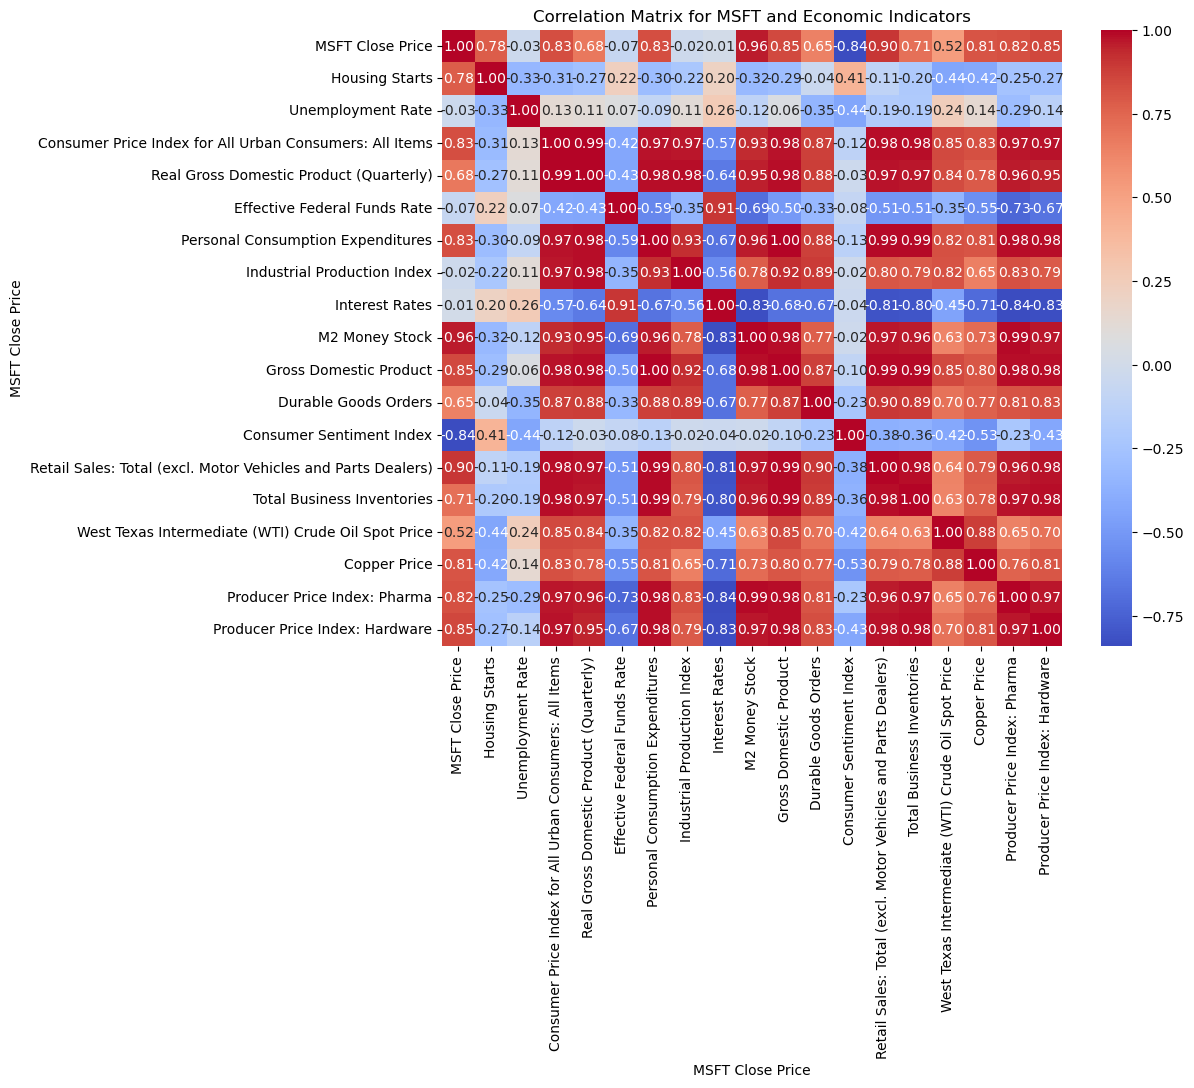

In [114]:
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from fredapi import Fred
import plotly.graph_objects as go
import plotly.io as pio
from prophet import Prophet
from newsapi import NewsApiClient
from tabulate import tabulate

class StockAnalysis:
    def __init__(self, tickers, start_date, end_date):
        """
        Initialize the StockAnalysis object.

        Parameters:
            tickers (list): List of tickers for which to perform the analysis.
            start_date (str): Start date for historical data (YYYY-MM-DD).
            end_date (str): End date for historical data (YYYY-MM-DD).
        """
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.all_traces = []
        self.closing_prices_df = pd.DataFrame()

    def fetch_stock_data(self, ticker):
        """
        Fetch historical stock data for the given ticker from Yahoo Finance.

        Parameters:
            ticker (str): Stock ticker symbol.

        Returns:
            pandas.DataFrame: DataFrame containing the historical stock data.
        """
        return yf.download(ticker, start=self.start_date, end=self.end_date, progress=False)

    def prepare_prophet_data(self, stock_data):
        prophet_data = stock_data.reset_index()[["Date", "Close"]]
        prophet_data.rename(columns={"Date": "ds", "Close": "y"}, inplace=True)
        return prophet_data

    def calculate_bollinger_bands(self, stock_data):
        window = 20
        std_dev = 2
        stock_data["MA"] = stock_data["Close"].rolling(window=window).mean()
        stock_data["Upper"] = stock_data["MA"] + std_dev * stock_data["Close"].rolling(window=window).std()
        stock_data["Lower"] = stock_data["MA"] - std_dev * stock_data["Close"].rolling(window=window).std()
        return stock_data

    def identify_bullish_bearish_signals(self, stock_data):
        bullish_signals = stock_data[stock_data["Close"] > stock_data["Upper"]]["Close"]
        bearish_signals = stock_data[stock_data["Close"] < stock_data["Lower"]]["Close"]
        return bullish_signals, bearish_signals

    def create_traces_for_ticker(self, ticker, stock_data, forecast, bullish_signals, bearish_signals):
        traces = [
            go.Scatter(x=stock_data.index, y=stock_data["Upper"], mode="lines", name=f"{ticker} Upper Bollinger Band", line=dict(color="blue")),
            go.Scatter(x=stock_data.index, y=stock_data["Lower"], mode="lines", name=f"{ticker} Lower Bollinger Band", line=dict(color="blue")),
            go.Scatter(x=stock_data.index, y=stock_data["Close"], mode="lines", name=f"{ticker} Closing Price", line=dict(color="black")),
            go.Scatter(x=forecast["ds"], y=forecast["yhat"], mode="lines", name=f"{ticker} Prophet Forecast", line=dict(color="purple")),
            go.Scatter(x=bullish_signals.index, y=bullish_signals, mode="markers", name=f"{ticker} Bullish Signal", marker=dict(symbol="triangle-up", size=10, color="green")),
            go.Scatter(x=bearish_signals.index, y=bearish_signals, mode="markers", name=f"{ticker} Bearish Signal", marker=dict(symbol="triangle-down", size=10, color="red")),
            go.Scatter(x=forecast["ds"], y=forecast["trend"], mode="lines", name=f"{ticker} Trend Line", line=dict(color="orange", dash="dash"))
        ]
        return traces

    def visualize_all_ticker_data(self):
        for ticker in self.tickers:
            stock_data = self.fetch_stock_data(ticker)
            self.closing_prices_df[ticker] = stock_data["Close"]
            prophet_data = self.prepare_prophet_data(stock_data)
            model = Prophet(daily_seasonality=True)
            model.fit(prophet_data)
            future = model.make_future_dataframe(periods=365) 
            forecast = model.predict(future)
            stock_data = self.calculate_bollinger_bands(stock_data)
            bullish_signals, bearish_signals = self.identify_bullish_bearish_signals(stock_data)
            traces = self.create_traces_for_ticker(ticker, stock_data, forecast, bullish_signals, bearish_signals)
            self.all_traces.extend(traces)

        fig = go.Figure(data=self.all_traces)
        today_date = datetime.today().strftime('%Y-%m-%d')
        fig.add_shape(
            type="line",
            x0=today_date,
            x1=today_date,
            y0=0,
            y1=1,
            xref="x",
            yref="paper",
            line=dict(color="gray", width=1.5, dash="dash"),
            name="Today's Date"
        )
        fig.add_annotation(
            x=today_date,
            y=0.9,
            xref="x",
            yref="paper",
            text="Today's Date",
            showarrow=True,
            font=dict(size=12, color="black"),
            align="center",
            arrowhead=1,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="black",
            ax=0,
            ay=-40
        )
        fig.update_layout(
            title=f"({', '.join(self.tickers)}) - Bollinger Bands, Prophet Forecast, and Bullish/Bearish Signals",
            xaxis_title="Date",
            template="plotly_white"
        )
        fig.show()

class News:
    def __init__(self, api_key):
        """
        Initialize the News object with the News API key.

        Parameters:
            api_key (str): Your News API key.
        """
        self.api_key = api_key

    def fetch_news_for_ticker(self, ticker):
        """
        Fetch financial news articles related to the given ticker.

        Parameters:
            ticker (str): Stock ticker symbol.

        Returns:
            list: List of news articles (title and URL) related to the given ticker.
        """
        newsapi = NewsApiClient(api_key=self.api_key)

        news_articles = []
        try:
            news_data = newsapi.get_everything(q=ticker, language='en', sort_by='publishedAt', page_size=5)
            articles = news_data['articles']
            for article in articles:
                title = article['title']
                url = article['url']
                news_articles.append({'Title': title, 'URL': url})
        except Exception as e:
            print(f"Error fetching news for {ticker}: {e}")

        return news_articles

class CorrelationVisualizer:
    def __init__(self, tickers, economic_indicators, start_date, today):
        """
        Initialize the CorrelationVisualizer object.

        Parameters:
            tickers (list): List of tickers for which you want to calculate the correlation matrix.
            economic_indicators (dict): A dictionary containing economic indicators and their series IDs.
            start_date (str): Start date in the format 'YYYY-MM-DD'.
            today (str): End date in the format 'YYYY-MM-DD'.
        """
        self.tickers = tickers
        self.economic_indicators = economic_indicators
        self.start_date = start_date
        self.today = today

    def fetch_economic_data(self, ticker):
        """
        Fetch economic indicator data for the chosen ticker from FRED API.

        Parameters:
            ticker (str): The ticker symbol for which to fetch economic indicator data.

        Returns:
            pandas.DataFrame: Dataframe containing economic indicator data for the chosen ticker.
        """
        # FRED API key (Get your API key from https://fred.stlouisfed.org/docs/api/api_key.html)
        API_KEY = "69fd7790faf0151554331d3354cd8ab4"

        # Create a FRED API client
        fred_client = Fred(api_key=API_KEY)

        # Fetch data for each economic indicator for the chosen ticker
        ticker_data = {}
        for series_id, series_name in self.economic_indicators.items():
            try:
                data = fred_client.get_series(series_id, start_date=self.start_date, end_date=self.today)
                ticker_data[series_name] = data
            except Exception as e:
                print(f"Error fetching data for {series_name} and {ticker}: {e}")

        # Create a data frame for the chosen ticker containing economic indicator data
        ticker_df = pd.DataFrame(ticker_data)
        return ticker_df

    def fetch_stock_data(self, ticker):
        """
        Fetch historical stock price data for the chosen ticker using yfinance.

        Parameters:
            ticker (str): The ticker symbol for which to fetch historical stock price data.

        Returns:
            pandas.DataFrame: Dataframe containing historical stock price data for the chosen ticker.
        """
        stock_data = yf.download(ticker, start=self.start_date, end=self.today)
        return stock_data

    def calculate_correlation_matrix(self, ticker_df, stock_data, ticker):
        """
        Calculate the correlation matrix for the chosen ticker.

        Parameters:
            ticker_df (pandas.DataFrame): Dataframe containing economic indicator data for the chosen ticker.
            stock_data (pandas.DataFrame): Dataframe containing historical stock price data for the chosen ticker.
            ticker (str): The ticker symbol for which to calculate the correlation matrix.

        Returns:
            pandas.DataFrame: Correlation matrix for the chosen ticker.
        """
        # Combine the ticker symbol and 'Close Price' to the data frame
        ticker_df[ticker + ' Close Price'] = stock_data['Close']

        # Move the ticker's column to the first position in the DataFrame
        ticker_position = ticker_df.columns.to_list().index(ticker + ' Close Price')
        columns_reordered = [ticker + ' Close Price'] + ticker_df.columns.to_list()[:ticker_position] + ticker_df.columns.to_list()[ticker_position+1:]
        correlation_matrix = ticker_df[columns_reordered].corr()

        # Transpose the correlation matrix to move the ticker to the top of the Y axis
        correlation_matrix = correlation_matrix.T
        return correlation_matrix

    def visualize_correlation_heatmap(self, ticker, correlation_matrix):
        """
        Visualize the correlation matrix as a heatmap using Seaborn.

        Parameters:
            ticker (str): The ticker symbol for which to visualize the correlation matrix.
            correlation_matrix (pandas.DataFrame): Correlation matrix for the chosen ticker.
        """
        # Create a correlation plot using Seaborn
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=True, yticklabels=True)
        plt.title(f"Correlation Matrix for {ticker} and Economic Indicators")
        plt.xlabel(f"{ticker} Close Price")
        plt.ylabel(f"{ticker} Close Price")

        # Adjust the x-axis ticks and labels to place them in the middle of each heatmap box
        x_labels = correlation_matrix.columns

        plt.show()

    def calculate_all_correlation_matrices(self):
        """
        Calculate correlation matrices for all tickers.

        Returns:
            dict: A dictionary containing correlation matrices for each ticker.
        """
        correlation_matrices = {}  # Dictionary to store correlation matrices for each ticker
        for ticker in self.tickers:
            ticker_df = self.fetch_economic_data(ticker)
            stock_data = self.fetch_stock_data(ticker)
            correlation_matrix = self.calculate_correlation_matrix(ticker_df, stock_data, ticker)
            correlation_matrices[ticker] = correlation_matrix
        return correlation_matrices

    def visualize_all_correlations(self):
        """
        Fetches data and visualizes correlation for all tickers.
        """
        correlation_matrices = self.calculate_all_correlation_matrices()
        for ticker, correlation_matrix in correlation_matrices.items():
            self.visualize_correlation_heatmap(ticker, correlation_matrix)


if __name__ == "__main__":
    # Common Economic Indicators from FRED with their series IDs
    economic_indicators = {
        'HOUST': "Housing Starts",
        'UNRATE': "Unemployment Rate",
        'CPIAUCSL': "Consumer Price Index for All Urban Consumers: All Items",
        'GDPC1': "Real Gross Domestic Product (Quarterly)",
        'FEDFUNDS': "Effective Federal Funds Rate",
        'PCE': "Personal Consumption Expenditures",
        'INDPRO': "Industrial Production Index",
        'DGS10': "10-Year Treasury Constant Maturity Rate",
        'M2': "M2 Money Stock",
        'GDP': "Gross Domestic Product",
        'DGORDER': "Durable Goods Orders",
        'UMCSENT': "Consumer Sentiment Index",
        'RSXFS': "Retail Sales: Total (excl. Motor Vehicles and Parts Dealers)",
        'BUSINV': "Total Business Inventories",
        'WTISPLC': "West Texas Intermediate (WTI) Crude Oil Spot Price",
        'PCOPPUSDM': "Copper Price",
        'DGS10': 'Interest Rates',
        'PCU325412325412': "Producer Price Index: Pharma",
        'PCU332510332510' : "Producer Price Index: Hardware"
        # Add more economic indicators and their series IDs as needed
    }
    
    # List of tickers for which you want to calculate the correlation matrix
    tickers_input = input("Enter the tickers (comma-separated): ")
    tickers = [ticker.strip().upper() for ticker in tickers_input.split(",")]
    start_date = (datetime.now() - timedelta(days=6 * 365)).strftime('%Y-%m-%d')
    today = datetime.now().strftime('%Y-%m-%d')

    # Create StockAnalysis object
    stock_analysis = StockAnalysis(tickers, start_date, end_date=today)

    # Perform analysis and visualize all ticker data
    stock_analysis.visualize_all_ticker_data()

    # Create News object with your News API key
    news_api_key = 'dfd56a5b546d469da6b0bb908d90b3eb'
    news_obj = News(news_api_key)

    # Fetch and display news for all tickers
    for ticker in tickers:
        print(f"\nNews for {ticker}:")
        news_articles = news_obj.fetch_news_for_ticker(ticker)
        print(tabulate(news_articles, headers="keys"))

    # Calculate correlation matrices and visualize correlations for all tickers
    correlation_visualizer = CorrelationVisualizer(tickers, economic_indicators, start_date, today)
    correlation_visualizer.visualize_all_correlations()
    
